# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [440]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [441]:
# Define transforms
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),                           
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
generator1 = torch.Generator().manual_seed(42)
data_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, valid_set = torch.utils.data.random_split(data_set, [0.7, 0.3], generator=generator1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=2)

# Create test set and define test dataloader
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [442]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


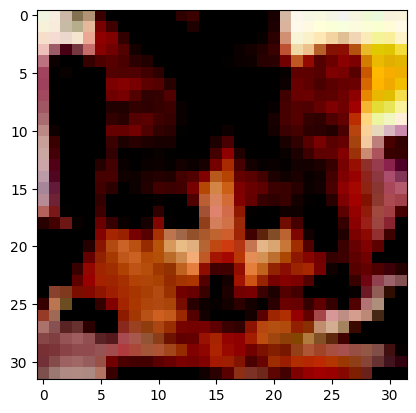

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


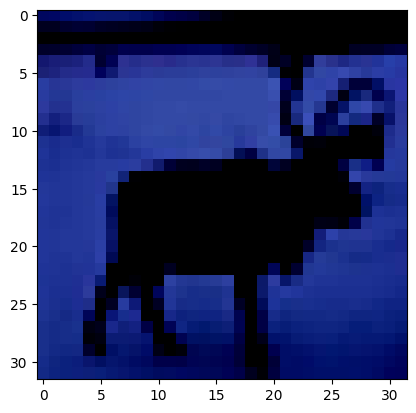

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


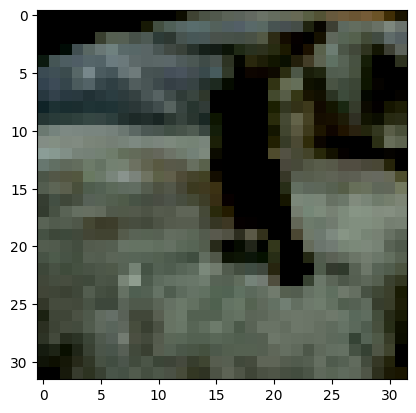

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


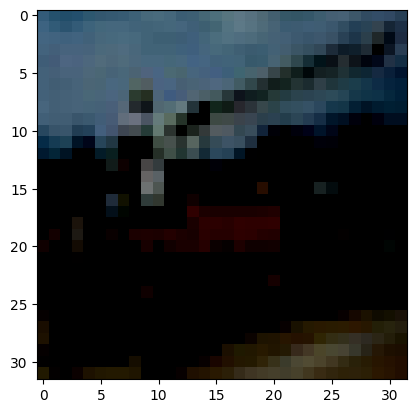

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


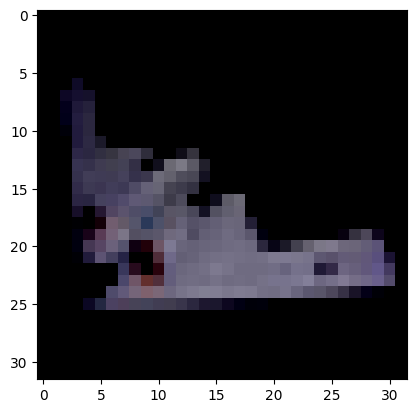

In [443]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [444]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 24, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [445]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [446]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [447]:
import copy

epochs = 25
train_losses = []
valid_losses = []
valid_accs = []

best_acc = 0

model.to(device)

for i in range(epochs):
    running_train_loss = 0

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    else:
        running_valid_loss = 0
        running_valid_acc = 0

        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                loss = criterion(output, labels)
                running_valid_loss += loss.item()

                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                running_valid_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        train_loss = running_train_loss / len(train_loader)
        valid_loss = running_valid_loss / len(valid_loader)
        valid_acc = running_valid_acc / len(valid_loader)

        if valid_acc > best_acc:
            best_model = copy.deepcopy(model)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        print(f"Eopch {i + 1}/{epochs}",
              f"Train loss: {train_loss:.3f}",
              f"Valid loss: {valid_loss:.3f}",
              f"Valid acc: {valid_acc:.3f}")

Eopch 1/25 Train loss: 1.465 Valid loss: 1.237 Valid acc: 0.555
Eopch 2/25 Train loss: 1.170 Valid loss: 1.160 Valid acc: 0.590
Eopch 3/25 Train loss: 1.077 Valid loss: 1.053 Valid acc: 0.625
Eopch 4/25 Train loss: 1.007 Valid loss: 1.010 Valid acc: 0.646
Eopch 5/25 Train loss: 0.957 Valid loss: 0.975 Valid acc: 0.649
Eopch 6/25 Train loss: 0.915 Valid loss: 0.945 Valid acc: 0.666
Eopch 7/25 Train loss: 0.884 Valid loss: 0.968 Valid acc: 0.661
Eopch 8/25 Train loss: 0.866 Valid loss: 0.914 Valid acc: 0.682
Eopch 9/25 Train loss: 0.831 Valid loss: 0.903 Valid acc: 0.684
Eopch 10/25 Train loss: 0.813 Valid loss: 0.888 Valid acc: 0.687
Eopch 11/25 Train loss: 0.793 Valid loss: 0.874 Valid acc: 0.697
Eopch 12/25 Train loss: 0.772 Valid loss: 0.889 Valid acc: 0.690
Eopch 13/25 Train loss: 0.758 Valid loss: 0.885 Valid acc: 0.692
Eopch 14/25 Train loss: 0.739 Valid loss: 0.890 Valid acc: 0.693
Eopch 15/25 Train loss: 0.721 Valid loss: 0.851 Valid acc: 0.703
Eopch 16/25 Train loss: 0.714 Vali

Plot the training loss (and validation loss/accuracy, if recorded).

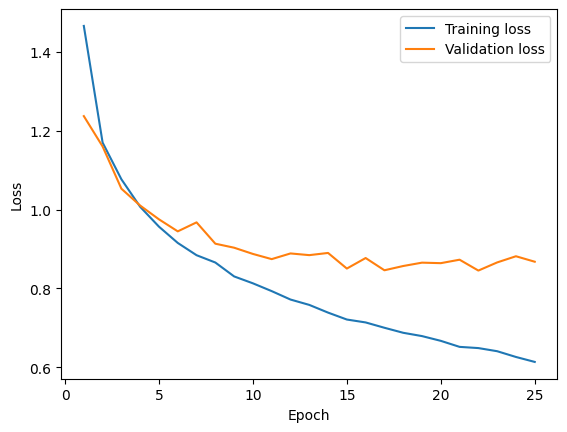

In [448]:
plt.plot(range(1, epochs + 1), train_losses, label='Training loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

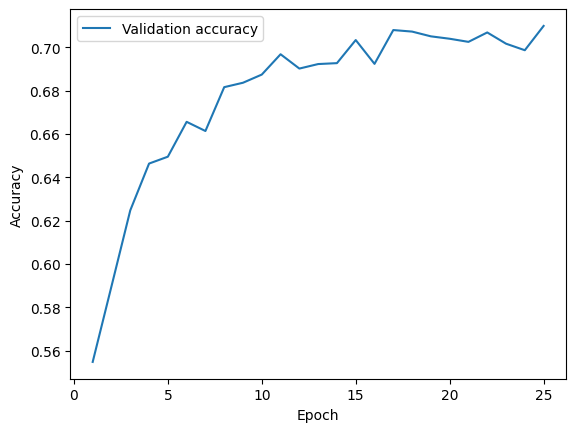

In [449]:
plt.plot(range(1, epochs + 1), valid_accs, label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [451]:
best_model.to(device)

running_loss = 0
running_acc = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()

        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        running_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
    test_loss = running_loss / len(test_loader)
    test_acc = running_acc / len(test_loader)

    print(f"Test loss: {test_loss:.3f} Test acc: {test_acc:.3f}")
        

Test loss: 0.877 Test acc: 0.700


## Saving your model
Using `torch.save`, save your model for future loading.

In [452]:
torch.save(best_model.state_dict(), 'best_model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

Based on the evaluation of my model, achieving a test set accuracy of 70%, which is the same as Detectocorp's model, it seems that building an in-house solution is a viable option. Let's analyze the different aspects to consider:

1. **Comparison with Detectocorp's model**:
   - My model achieved the same accuracy as Detectocorp's model on the CIFAR-10 dataset, which suggests that your in-house solution is competitive with what's available on the market.

2. **Comparison with state-of-the-art results**:
   - While my model's accuracy of 70% is not as high as some of the state-of-the-art results mentioned in the literature (e.g., 99% accuracy with GPipe), it's important to recognize that these models are often much larger and computationally expensive. My model, which is a relatively simple convolutional neural network, performs reasonably well given its simplicity.

3. **Approach for achieving accuracy**:
   - My model architecture consists of several convolutional layers followed by fully connected layers. I've incorporated batch normalization, max-pooling, and ReLU activation functions, which are common techniques used to improve the performance of neural networks. Additionally, you've employed data augmentation during training, which helps in generalization and improves the model's ability to learn from limited data.

4. **Necessity of improving accuracy**:
   - While achieving a 70% accuracy is a good starting point, there's room for improvement. If the goal is to surpass Detectocorp's model or achieve higher accuracy comparable to state-of-the-art results, further experimentation and optimization would be required. This might involve exploring more complex network architectures, experimenting with different optimization techniques, adjusting hyperparameters, increasing the amount of training data, or even considering more advanced techniques like transfer learning.

Given these considerations, here's the recommendation:

**Recommendation: Build the solution in-house**
- My in-house solution demonstrates competitive performance with Detectocorp's model on the CIFAR-10 dataset. Since my model achieves the same accuracy without additional cost, it's more cost-effective and flexible to continue developing and refining my in-house solution. As I gain more experience and resources, I can explore ways to further enhance the model's performance and potentially surpass existing benchmarks. Additionally, having control over the development process allows for customization and adaptation to specific requirements and future challenges in the domain of self-driving cars.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).